# Univariate Time Series
## The Box-Jenkins metodology is used in this analysis.  

In [43]:
#################################################################
#################################################################
#####   Class 4 - Time Series                                ####
#####   Creation Date: 20200415                              ####
#####   Final Edition Date: 20200415                         ####
#####   Autor: Edgar Javier López Moreno                     ####  
#####   E-mail: ejlopezmor@gmail.com                         ####
#################################################################
#################################################################

rm(list = ls())
# https://stats.stackexchange.com/questions/229948/plotting-predicted-values-in-arima-time-series-in-r/353375
# https://rpubs.com/riazakhan94/arima_with_example
# http://homepage.divms.uiowa.edu/~kchan/TSA.htm

#################################################################
#####                      Library used                     #####   
#################################################################

#library(astsa)
library(tseries)
library(forecast)
library(ggplot2)
library(readr)
library(gridExtra)
library(MASS)
#library(RSocrata)
#library(readxl)
#library(ggfortify)

#################################################################
#####                    Load information                   #####   
#################################################################

url_hare <- 'http://homepage.divms.uiowa.edu/~kchan/TSA/Datasets/hare.dat'
hare.db  <- as.vector(data.frame(read_csv(url_hare))$hare)
hare     <- ts(hare.db, start(1905), frequency = 1)

Parsed with column specification:
cols(
  hare = col_double()
)


## Specification
### Apply the Box-Jenkins metodology to Hare data. 

Warning message in adf.test(hare^0.5):
"p-value smaller than printed p-value"


	Augmented Dickey-Fuller Test

data:  hare^0.5
Dickey-Fuller = -4.479, Lag order = 3, p-value = 0.01
alternative hypothesis: stationary


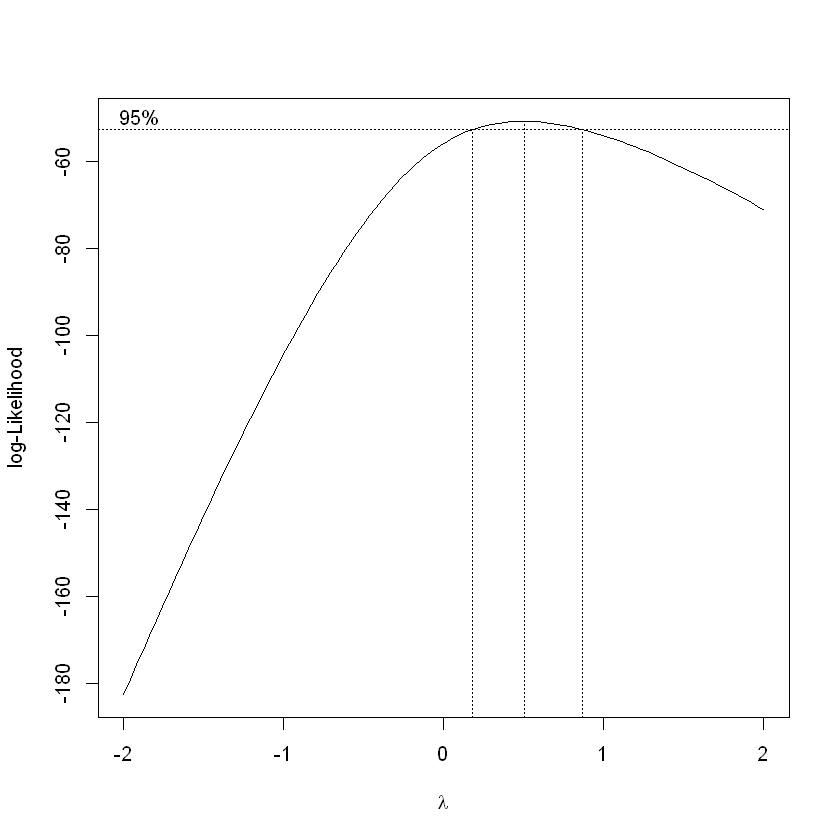

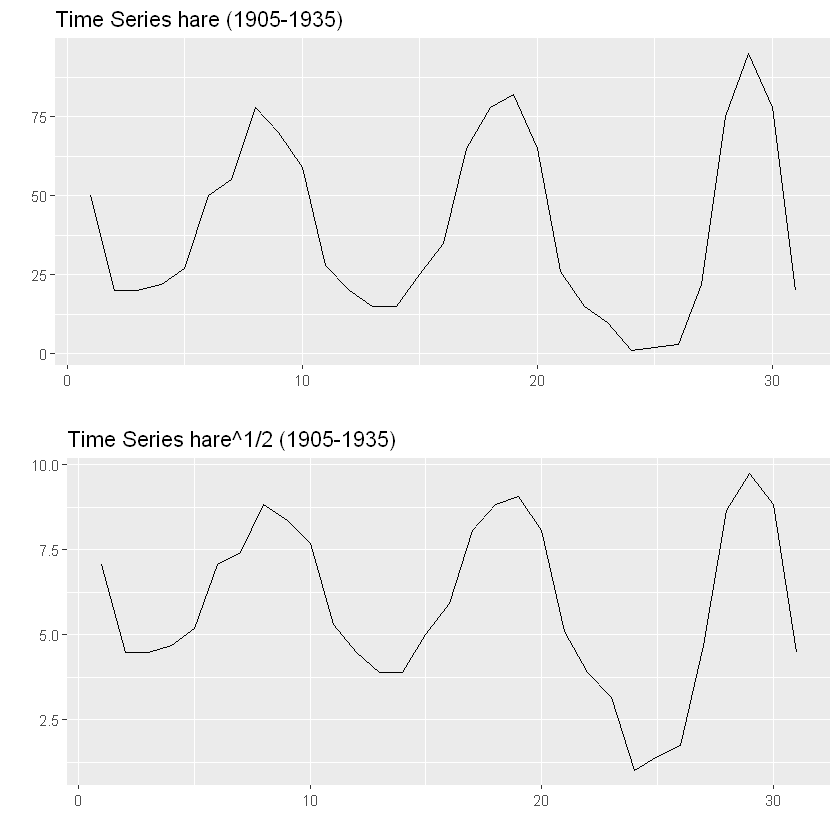

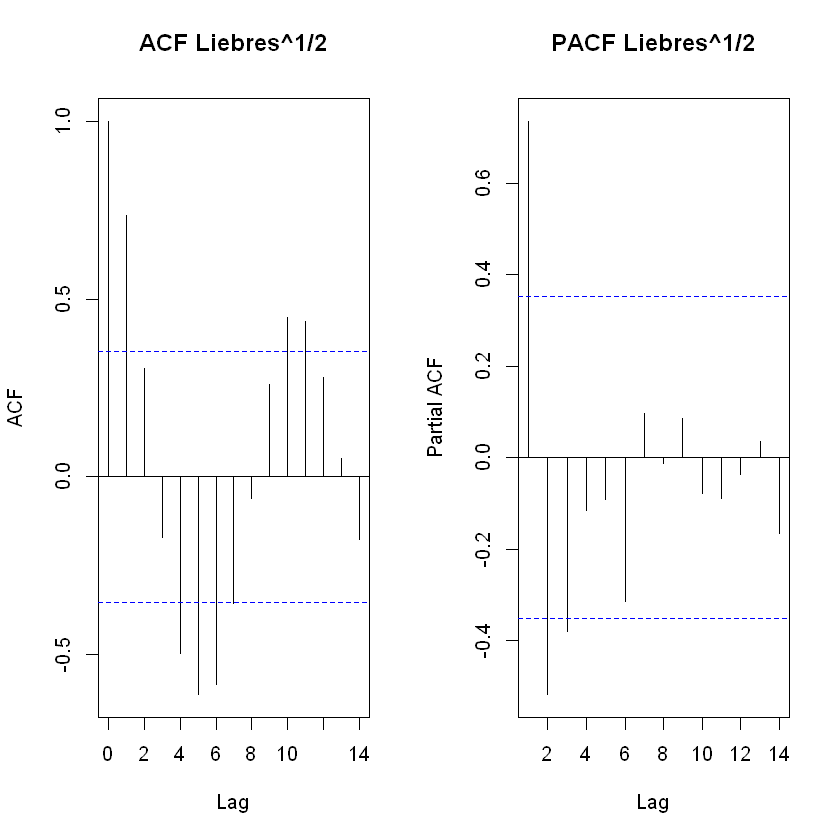

In [56]:
boxcox(hare ~ 1)
adf.test(hare^0.5)

grid.arrange(autoplot(hare, main = 'Time Series hare (1905-1935)'),
             autoplot(hare^0.5, main = 'Time Series hare^1/2 (1905-1935)'),
             ncol = 1)

par(mfrow=c(1,2))
acf(hare^0.5, main = 'ACF Liebres^1/2')
pacf(hare^0.5, main = 'PACF Liebres^1/2')


## Estimation and diagnostic

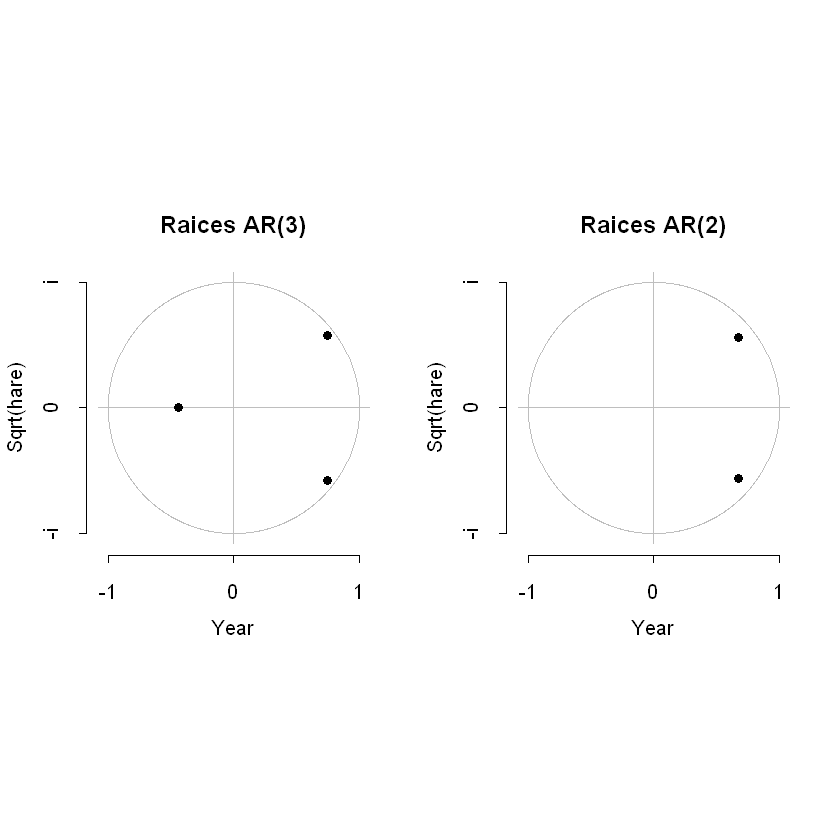

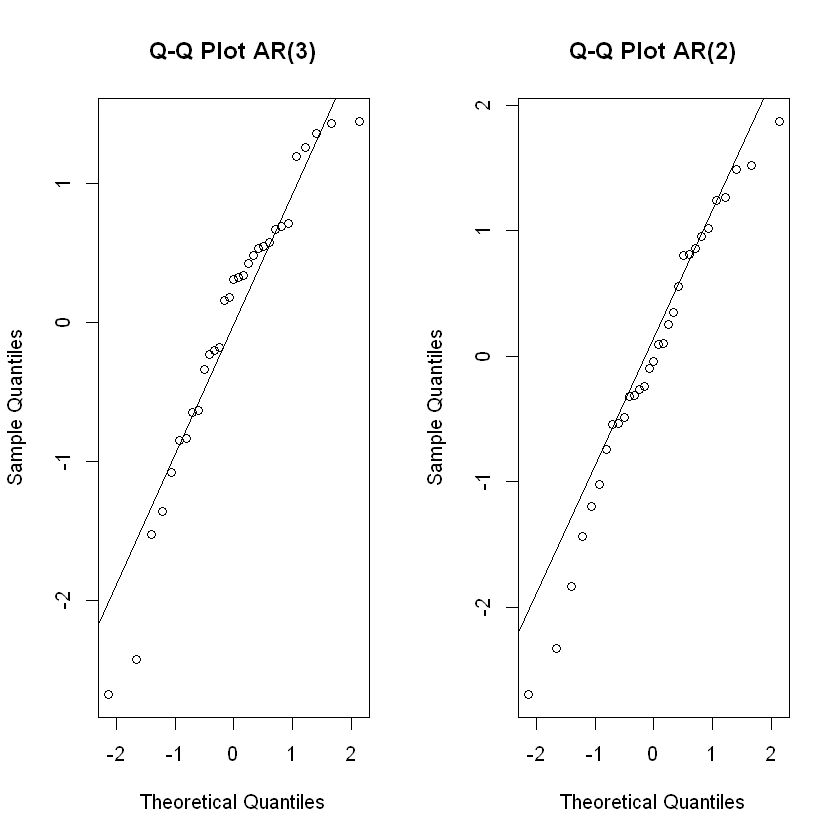

, , 1

              [,1]
 [1,]  1.000000000
 [2,] -0.261159571
 [3,]  0.238633270
 [4,] -0.008772399
 [5,] -0.317890781
 [6,]  0.284795028
 [7,] -0.185661771
 [8,]  0.114181194
 [9,] -0.023858448
[10,]  0.042287069
[11,]  0.101795821
[12,]  0.095242077
[13,] -0.074824209
[14,]  0.010903743
[15,] -0.083024441

[1]  1.0000 -0.2600  0.2400 -0.0088 -0.3200  0.2800

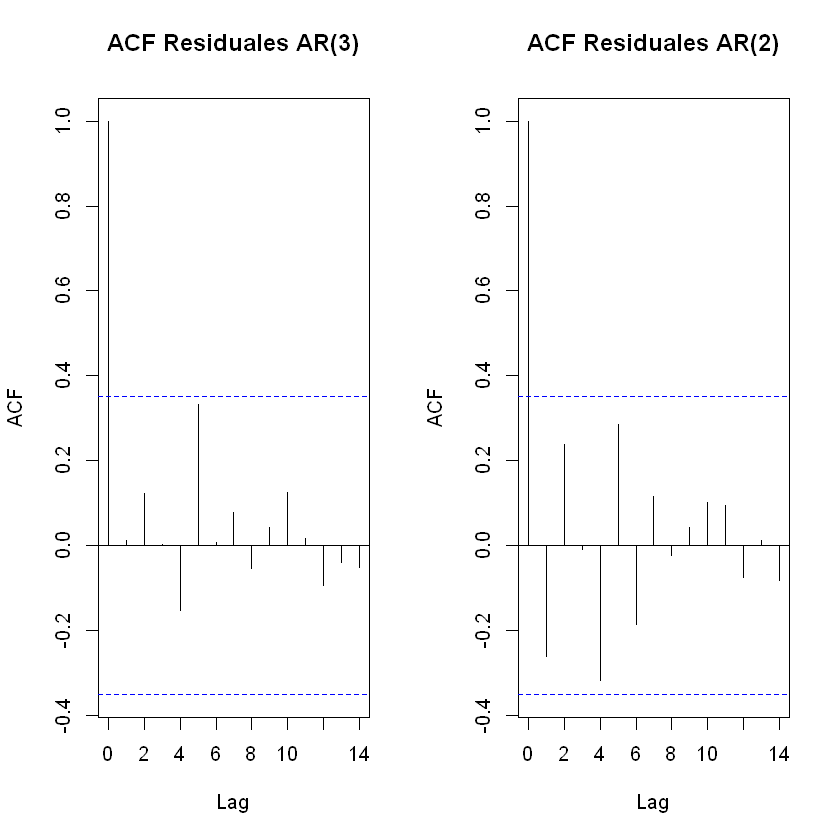


	Box-Ljung test

data:  resid(m2.hare)
X-squared = 11.358, df = 4, p-value = 0.02283


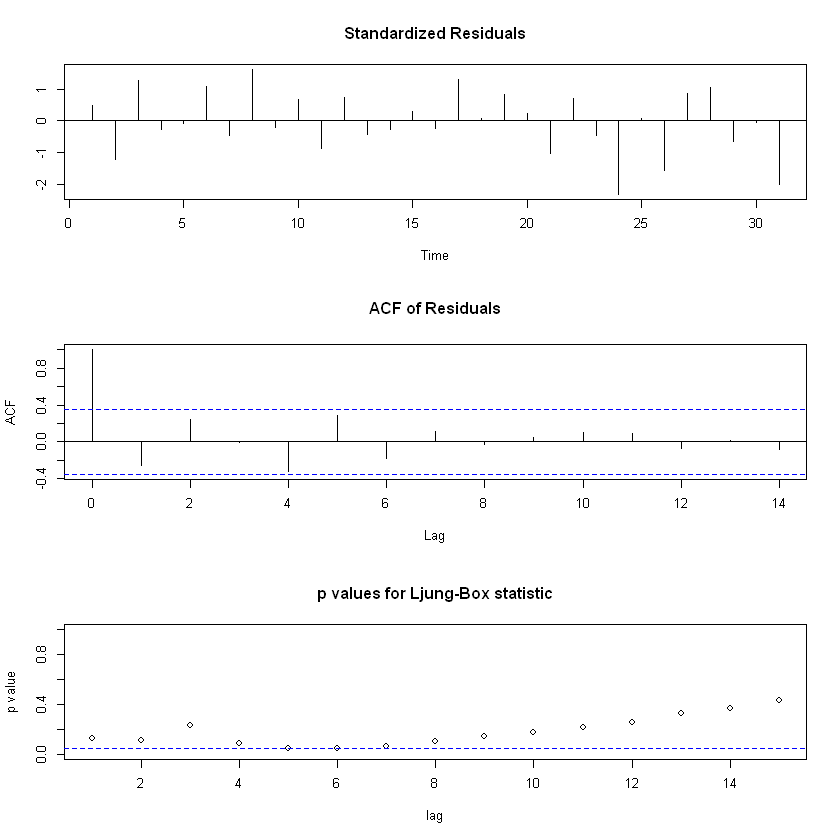

In [57]:
m1.hare <- Arima(hare^0.5, order=c(3,0,0),method='ML')
m2.hare <- Arima(hare^0.5, order=c(2,0,0),method='ML')

par(mfrow=c(1,2))
plot(m1.hare, type='b', xlab='Year',ylab='Sqrt(hare)', main = 'Raices AR(3)')
plot(m2.hare, type='b', xlab='Year',ylab='Sqrt(hare)', main = 'Raices AR(2)')

qqnorm(residuals(m1.hare), main = 'Q-Q Plot AR(3)'); qqline(residuals(m1.hare))
qqnorm(residuals(m2.hare), main = 'Q-Q Plot AR(2)'); qqline(residuals(m2.hare))
acf(residuals(m1.hare), main = 'ACF Residuales AR(3)')
acf(residuals(m2.hare), main = 'ACF Residuales AR(2)')

acf(residuals(m2.hare),plot=F)$acf
signif(acf(residuals(m2.hare),plot=F)$acf[1:6],2)
tsdiag(m2.hare, gof=15, omit.initial=F)
Box.test(resid(m2.hare),type="Ljung",lag=5,fitdf=1)

## Forecast


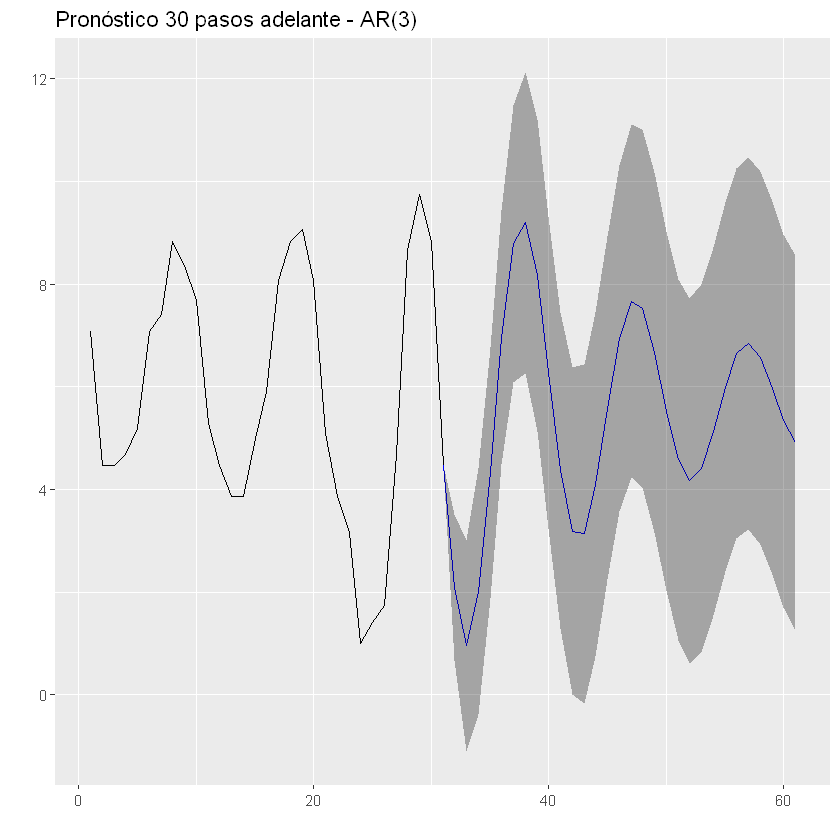

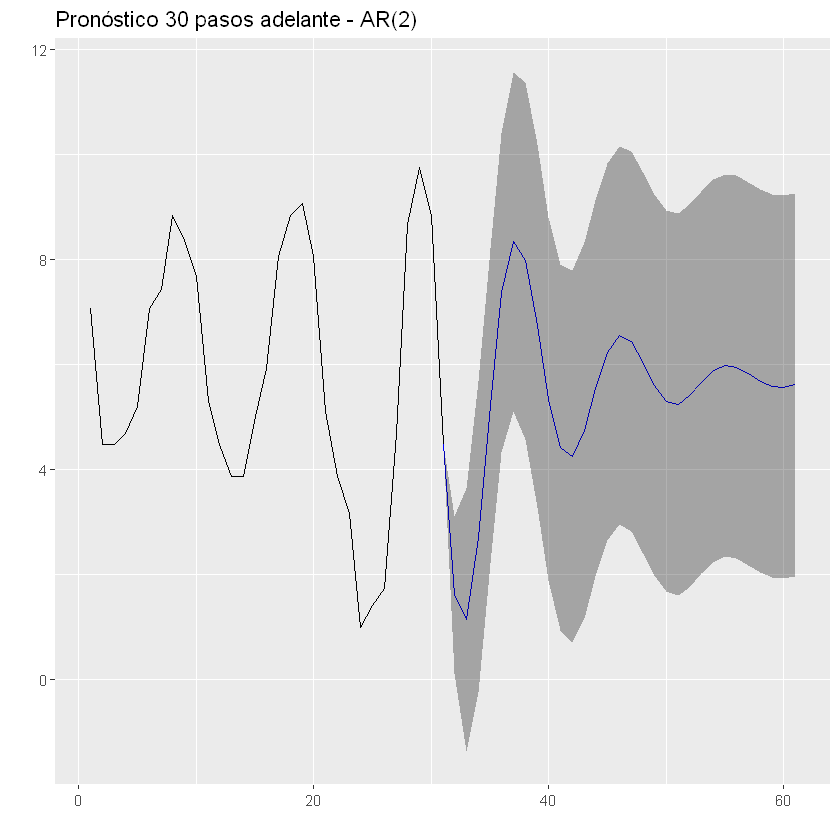

In [58]:
autoplot(forecast(m1.hare, h = 30), main = 'Pronóstico 30 pasos adelante - AR(3)')
autoplot(forecast(m2.hare, h = 30), main = 'Pronóstico 30 pasos adelante - AR(2)')


In [59]:
#################################################################
#####                         Functions                     #####  
#################################################################


HWplot <- function(ts_object,  n.ahead=4,  CI=.95,  error.ribbon='green', line.size=1){

    hw_object  <- HoltWinters(ts_object)   
    forecast   <- predict(hw_object,  n.ahead=n.ahead,  prediction.interval=T,  level=CI)
    for_values <- data.frame(time=round(time(forecast),  3),  value_forecast=as.data.frame(forecast)$fit,  dev=as.data.frame(forecast)$upr-as.data.frame(forecast)$fit)
    fitted_values <- data.frame(time=round(time(hw_object$fitted),  3),  value_fitted=as.data.frame(hw_object$fitted)$xhat)
    actual_values <- data.frame(time=round(time(hw_object$x),  3),  Actual=c(hw_object$x))    
    
    graphset <- merge(actual_values,  fitted_values,  by='time',  all=TRUE)
    graphset <- merge(graphset,  for_values,  all=TRUE,  by='time')
    graphset[is.na(graphset$dev),  ]$dev<-0
    graphset$Fitted <- c(rep(NA,  NROW(graphset)-(NROW(for_values) + NROW(fitted_values))),  fitted_values$value_fitted,  for_values$value_forecast)
    graphset <- data.table(graphset)
    
    graphset.melt <- melt(graphset[, c('time', 'Actual', 'Fitted')], id='time')
    p <- ggplot(graphset.melt,  aes(x=time,  y=value)) + 
    geom_ribbon(data=graphset, aes(x=time, y=Fitted, ymin=Fitted-dev,  ymax=Fitted + dev),  alpha=.2,  fill=error.ribbon) + 
    geom_line(aes(colour=variable), size=line.size) + 
    #geom_vline(x=max(actual_values$time),  lty=2) + 
    xlab('Time') + ylab('Value') + scale_colour_hue('')
    
    return(list(plot = p, prono = forecast))
}